In [1]:
import pandas as pd
import numpy as np
import glob as glob
import os
import cv2
import matplotlib.pyplot as plt
import argparse
import time
from tqdm.auto import tqdm
import keras
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader, random_split
from pytorch_model_summary import summary
from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings('ignore')

from Constant import *
from dataset import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [3]:
gpu = torch.cuda.is_available()
gpu

False

In [4]:
dataset = keras.preprocessing.image_dataset_from_directory(TRAIN_PATH,
                                                           shuffle = True,
                                                           image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size = BATCH_SIZE)

Found 2100 files belonging to 2 classes.


In [5]:
image_count = len(dataset)
image_count

132

In [6]:
class_names = dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['cats', 'dogs']
2


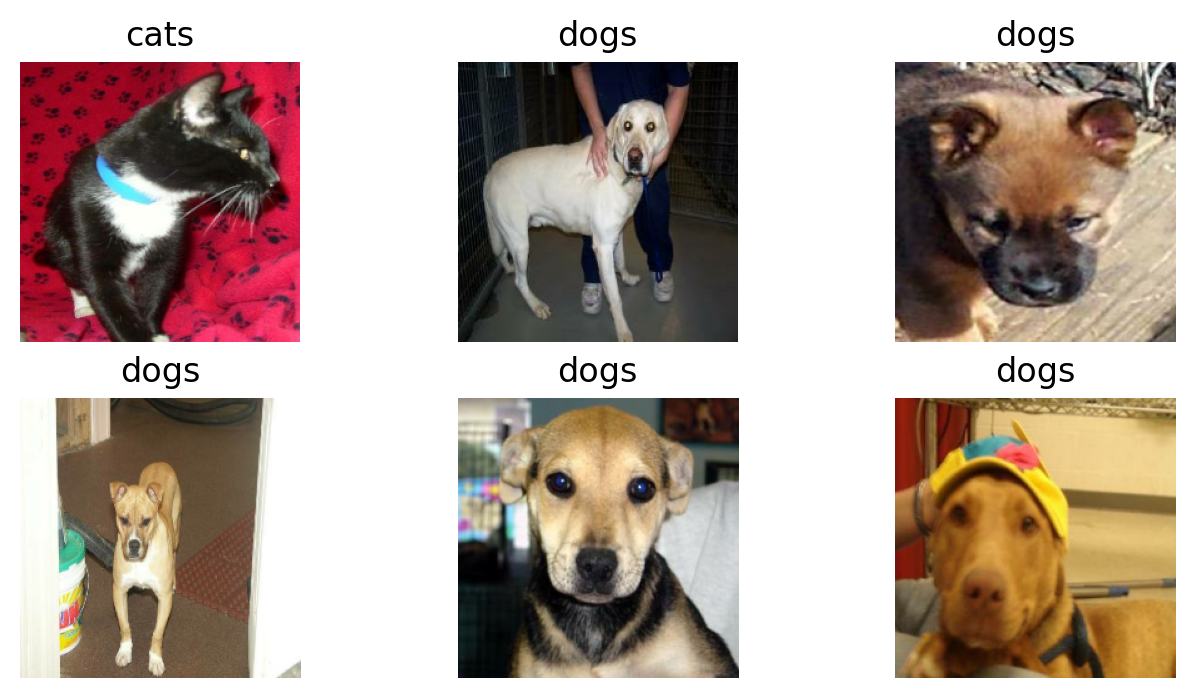

In [7]:
plt.figure(figsize = (8, 4))
for image_batch, label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def train_preprocessing(IMAGE_SIZE):
    train_augmenting = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p = 0.6),
        transforms.RandomVerticalFlip(p = 0.6),
        transforms.GaussianBlur(kernel_size = (5, 9),sigma = (0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor = 2, p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.465, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])
    
    return train_augmenting

In [9]:
dataset = datasets.ImageFolder(TRAIN_PATH,
                               transform = (train_preprocessing(IMAGE_SIZE)))
dataset_size = [int(len(dataset) * 0.75), len(dataset) - int(len(dataset) * 0.75)]
train_set, validation_set = random_split(dataset, dataset_size)

def file_loader(train_set, validation_set):
    train_loader = DataLoader(
        train_set,
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS
    )
    validation_loader = DataLoader(
        validation_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
        num_workers = NUM_WORKERS
    )
    
    return train_loader, validation_loader

In [10]:
dataset.class_to_idx

{'cats': 0, 'dogs': 1}

In [11]:
plt.style.use('ggplot')

def save_model(epochs, model, optimizer, criterion):
    torch.save({
        'epoch' : epochs,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : criterion,
    }, f"../outputs2/model.pth")
    
    
def save_plots(train_accuracy, validation_accuracy, train_loss, validation_loss):
    # Accuracy plot
    plt.figure(figsize = (10, 8))
    plt.plot(train_accuracy, color = 'black', label = 'training accuracy')
    plt.plot(validation_accuracy, color = 'blue', label = 'validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"../outputs2/accuracy.png")
    
    # Loss plot
    plt.figure(figsize = (10, 8))
    plt.plot(train_loss, color = 'black', label = 'training loss')
    plt.plot(validation_loss, color = 'blue', label = 'validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"../outputs2/loss.png")

In [12]:
# Using efficientnet
    
    
def build_model(pretrained = True, fine_tune = True, num_classes = 2):

    # Load the pre-trained ResNet model
    model = EfficientNet.from_pretrained('efficientnet-b0')

    # Freeze all layers if fine-tuning is not enabled
    return model


In [13]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print("Training...")
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    
    for i, data in tqdm(enumerate(trainloader), total = len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        # Forward prop
        outputs = model(image)
        
        # Calculating loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        
        # Calculating accuracy
        _, prediction = torch.max(outputs.data, 1)
        train_running_correct += (prediction == labels).sum().item()
        
        # Backward prop
        loss.backward()

        # Update weights
        optimizer.step()
        
    epoch_loss = train_running_loss / counter
    epoch_accuracy = 100 * (train_running_correct / len(trainloader.dataset))
    
    return epoch_loss, epoch_accuracy

In [14]:
def validate(model, testloader, criterion):
    model.eval()
    print('validation...')
    validation_running_loss = 0.0
    validation_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # Forward prop
            outputs = model(image)
            
            # Calculating loss
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            
            # Calculating accuracy
            _, prediction = torch.max(outputs.data, 1)
            validation_running_correct += (prediction == labels).sum().item()
            
    epoch_loss = validation_running_loss / counter
    epoch_accuracy = 100 * (validation_running_correct / len(testloader.dataset))
    
    return epoch_loss, epoch_accuracy


In [15]:
args = {'learning_rate' : 0.0001, 'epochs' : 15}
dataset_classes = dataset.class_to_idx

In [16]:
# Load training and validation data loaders
train_loader, validation_loader = file_loader(train_set, validation_set)

In [17]:
%%time

# Learning parameters
learning_rate = args['learning_rate']
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}\n")


# Make custom model and call here
    
model = build_model(
        pretrained = True,
        fine_tune = True,
        num_classes = len(dataset_classes)
    ).to(device)
    
 
# Total parameters and trainable parameters
total_parameters = sum(p.numel() for p in model.parameters())
print(f"{total_parameters:,} parameters.")
trainable_parameters = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
print(f"{trainable_parameters:,} training parameters.")
    
    # Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    # Loss
criterion = nn.CrossEntropyLoss()
    
    # Tracking loss and accuracy
train_loss, validation_loss = [], []
train_accuracy, validation_accuracy = [], []
    
    # Train
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_loss_per_epoch, train_accuracy_per_epoch = train(model,
                                                               train_loader,
                                                               optimizer,
                                                               criterion)
    val_loss_per_epoch, val_accuracy_per_epoch = validate(model,
                                                              validation_loader,
                                                              criterion)
    train_loss.append(train_loss_per_epoch)
    validation_loss.append(val_loss_per_epoch)
    train_accuracy.append(train_accuracy_per_epoch)
    validation_accuracy.append(val_accuracy_per_epoch)
    print(f"Training loss: {train_loss_per_epoch:.3f}, Training accuracy: {train_accuracy_per_epoch:.3f}")
    print(f"Validation loss: {val_loss_per_epoch:.3f}, Validation accuracy: {val_accuracy_per_epoch:.3f}")
    print("~ " * 100)
    time.sleep(3)
        
print("Done")

Running on: cpu
Learning rate: 0.0001
Epochs: 15

Loaded pretrained weights for efficientnet-b0
5,288,548 parameters.
5,288,548 training parameters.
Epoch 1 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 2.960, Training accuracy: 53.905
Validation loss: 0.349, Validation accuracy: 91.810
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 2 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.265, Training accuracy: 90.921
Validation loss: 0.180, Validation accuracy: 94.857
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 3 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.174, Training accuracy: 93.778
Validation loss: 0.149, Validation accuracy: 94.667
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 4 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.153, Training accuracy: 94.603
Validation loss: 0.122, Validation accuracy: 96.571
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 5 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.110, Training accuracy: 96.508
Validation loss: 0.093, Validation accuracy: 97.333
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 6 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.091, Training accuracy: 96.635
Validation loss: 0.105, Validation accuracy: 96.000
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 7 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.092, Training accuracy: 96.508
Validation loss: 0.118, Validation accuracy: 96.000
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 8 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.093, Training accuracy: 96.381
Validation loss: 0.086, Validation accuracy: 96.571
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 9 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.074, Training accuracy: 97.333
Validation loss: 0.084, Validation accuracy: 96.952
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 10 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.072, Training accuracy: 97.905
Validation loss: 0.075, Validation accuracy: 97.333
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 11 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.066, Training accuracy: 97.651
Validation loss: 0.090, Validation accuracy: 97.143
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 12 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.051, Training accuracy: 98.095
Validation loss: 0.093, Validation accuracy: 96.571
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 13 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.057, Training accuracy: 98.032
Validation loss: 0.091, Validation accuracy: 96.381
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 14 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.029, Training accuracy: 99.048
Validation loss: 0.075, Validation accuracy: 97.714
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 15 of 15
Training...


  0%|          | 0/99 [00:00<?, ?it/s]

validation...


  0%|          | 0/33 [00:00<?, ?it/s]

Training loss: 0.049, Training accuracy: 98.095
Validation loss: 0.098, Validation accuracy: 96.000
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Done
CPU times: total: 4h 55min 21s
Wall time: 2h 45min 39s


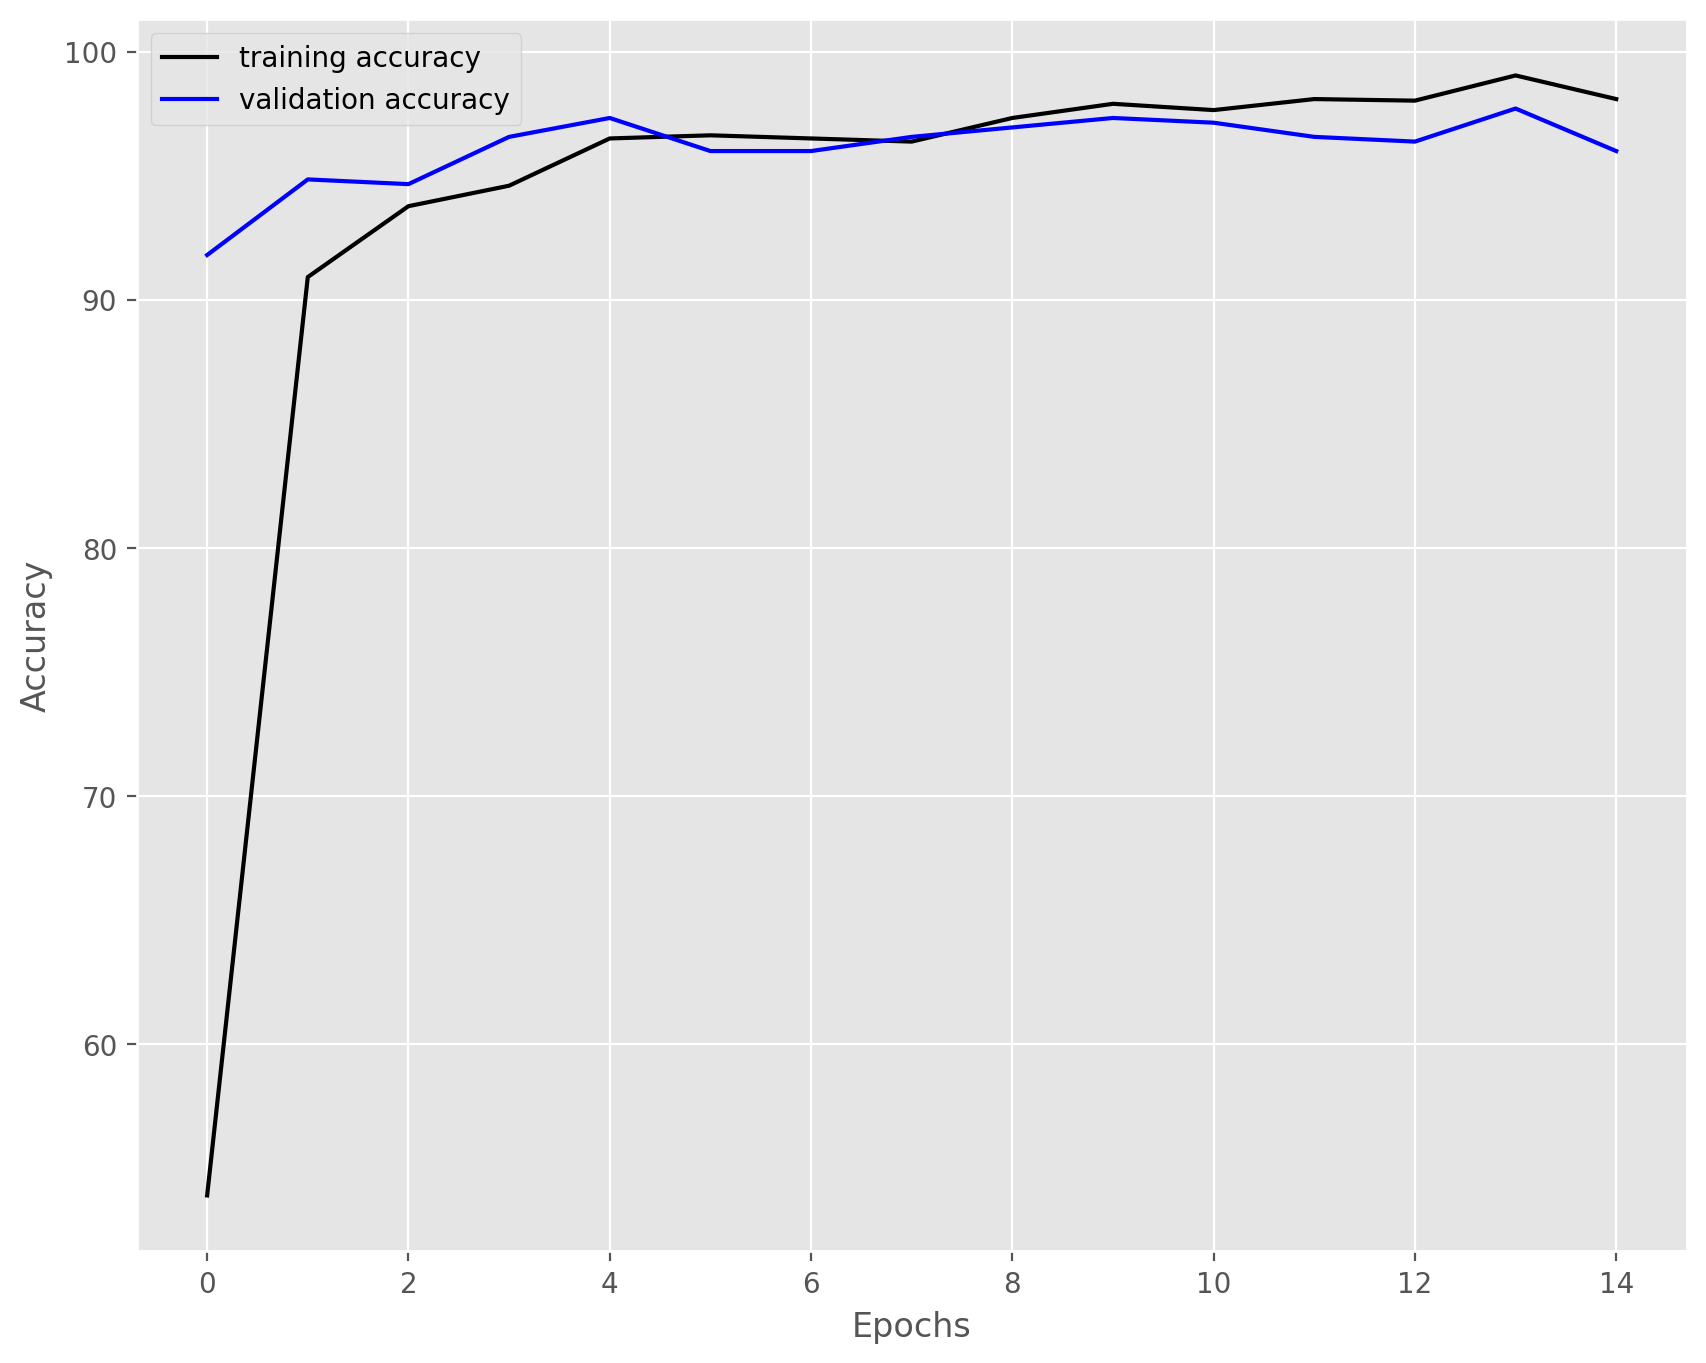

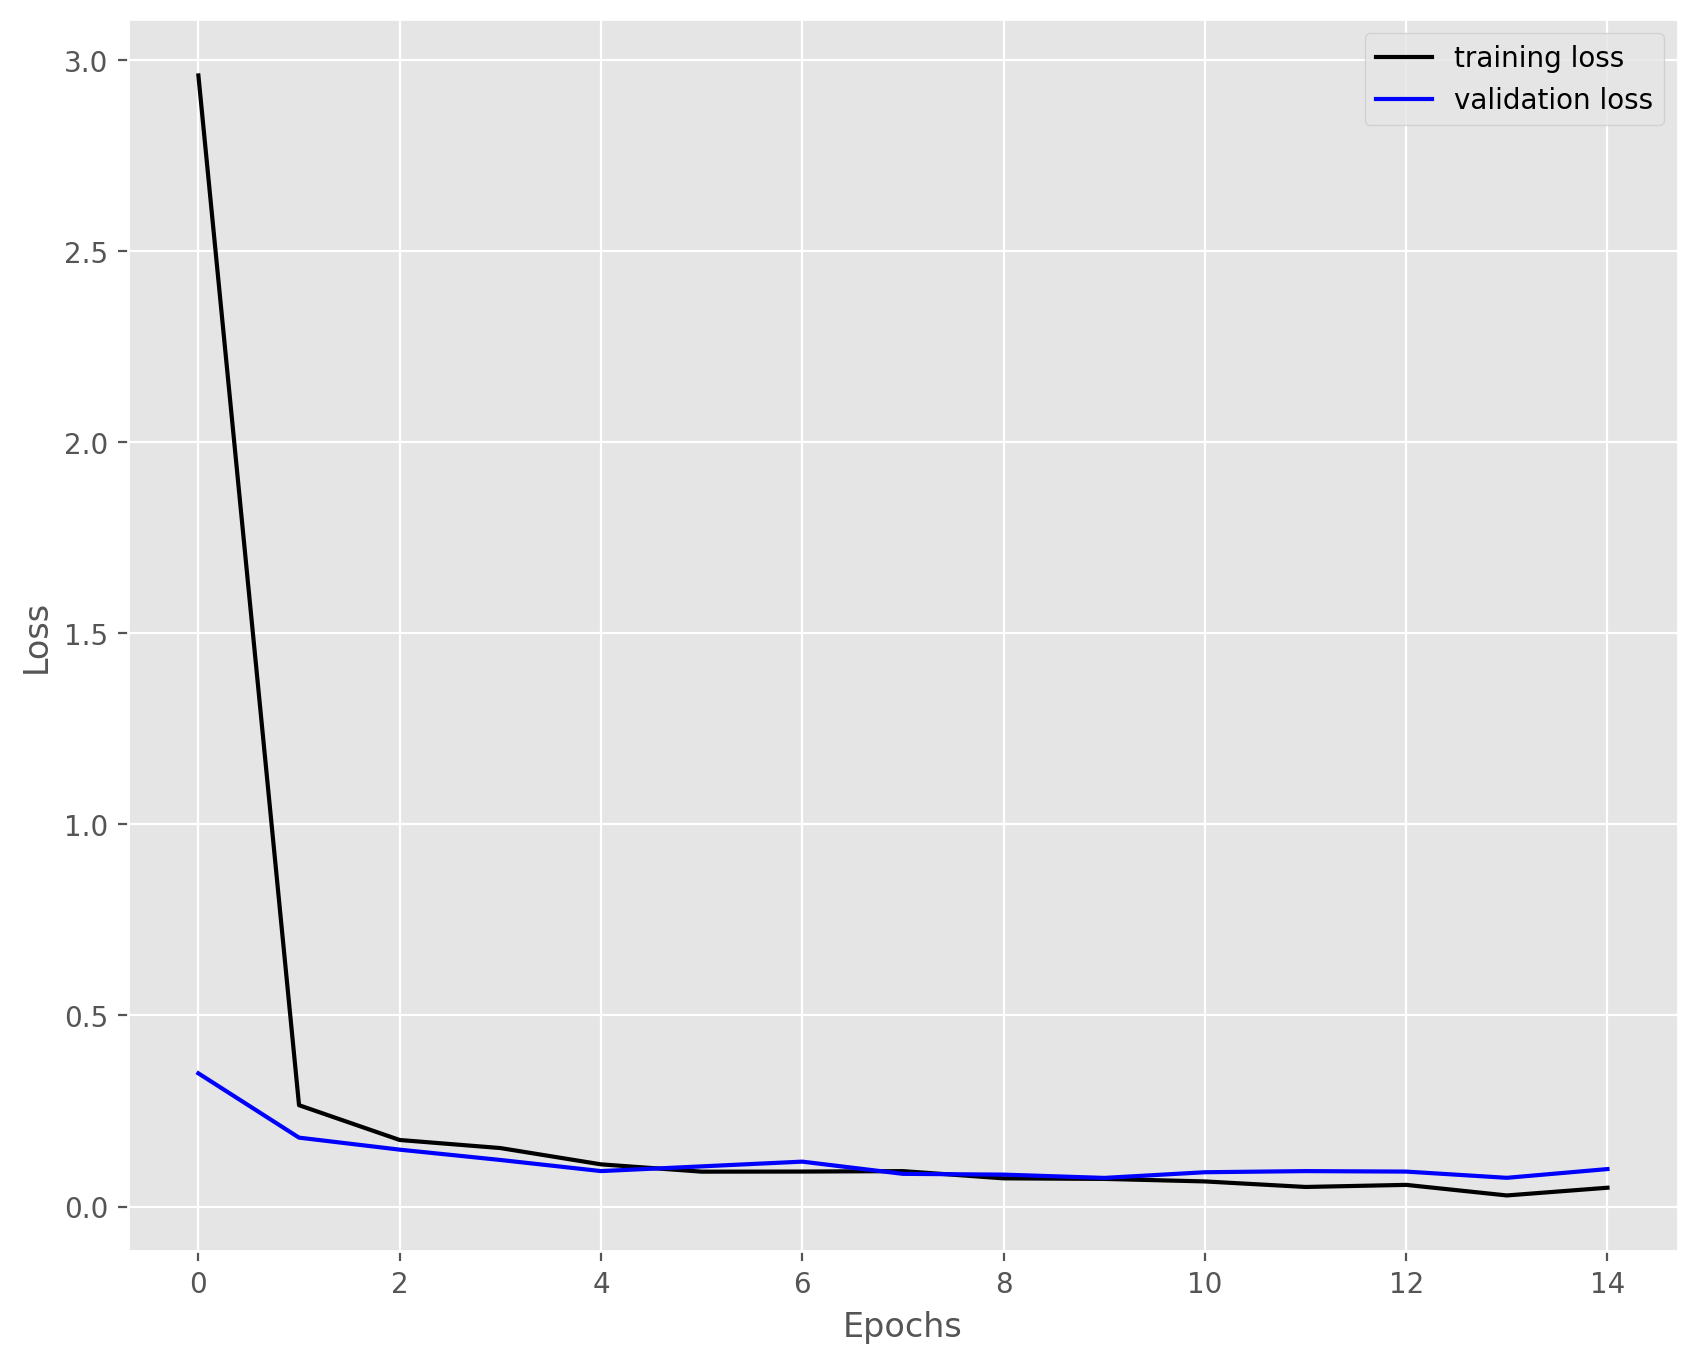

In [18]:
    # Save model
save_model(epochs, model, optimizer, criterion)

    # Save loss and accuracy plots
save_plots(train_accuracy, validation_accuracy, train_loss, validation_loss)

In [19]:
# Load saved model
model = build_model(pretrained = False, fine_tune = False, num_classes = 2)
checkpoint = torch.load("../outputs2/model.pth", map_location = DEVICE)
#print("Loading saved model")
model.load_state_dict(checkpoint['model_state_dict'])

# Get test files
test_files = glob.glob(f"{TEST_PATH}/*")

# Iterate over images
for test_file in test_files:
    # Get true class name and make copy
    actual_class = test_file.split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_file)
    test_image = image.copy()
    
    # Preprocess images
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.465, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    image = image.to(DEVICE)
    
    # Test on image
    outputs = model(image)
    outputs = outputs.detach().numpy()
    predicted_class = class_names[np.argmax(outputs[0])]
    print(f"Predicted: {predicted_class.lower()}\t Actual class: {actual_class}")
    
    # Inscribe the text onto the images
    cv2.putText(
        test_image,
        f"Actual: {actual_class}",
        (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (100, 200, 125),
        1,
        lineType = cv2.LINE_AA
    )
    cv2.putText(
        test_image,
        f"Predicted: {predicted_class.lower()}",
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (65, 65, 155),
        1,
        lineType = cv2.LINE_AA
    )
    

    cv2.imwrite(f"../outputs2/{actual_class}.png", test_image)

Loaded pretrained weights for efficientnet-b0
Predicted: cats	 Actual class: c
Predicted: dogs	 Actual class: cat
Predicted: cats	 Actual class: cat_
Predicted: cats	 Actual class: cat_2
Predicted: cats	 Actual class: c_
Predicted: cats	 Actual class: c_1
Predicted: cats	 Actual class: c_2
Predicted: dogs	 Actual class: c_3
Predicted: cats	 Actual class: c_4
Predicted: cats	 Actual class: d
Predicted: cats	 Actual class: dog
Predicted: dogs	 Actual class: dog_
Predicted: dogs	 Actual class: dog_2
Predicted: cats	 Actual class: d_
Predicted: dogs	 Actual class: d_1
Predicted: cats	 Actual class: d_2
Predicted: dogs	 Actual class: d_3
Predicted: dogs	 Actual class: d_4
